### Reading data

In [5]:
import pandas as pd
from sclibrary.read_data import GraphDataReader

data_folder = 'data/london_street'

#### Option 1: CSV

In [6]:
# read csv
filename = data_folder + '/LondonEdges.csv'
G = GraphDataReader.read_csv(filename=filename, delimeter=" ", src_col='Source', dest_col='Target', feature_cols=['distance'])
simplices = G.simplicies(conditional_triangles=False)
simplices

[[3],
 [7],
 [9],
 [18],
 [23],
 [25],
 [38],
 [44],
 [45],
 [39],
 [27],
 [24],
 [20],
 [12],
 [8],
 [6],
 [1],
 [16],
 [35],
 [40],
 [46],
 [42],
 [37],
 [28],
 [30],
 [33],
 [34],
 [26],
 [36],
 [48],
 [43],
 [47],
 [57],
 [60],
 [66],
 [4],
 [10],
 [13],
 [11],
 [15],
 [17],
 [5],
 [21],
 [32],
 [31],
 [51],
 [50],
 [49],
 [54],
 [55],
 [52],
 [59],
 [61],
 [58],
 [62],
 [64],
 [65],
 [69],
 [56],
 [2],
 [14],
 [19],
 [22],
 [29],
 [41],
 [53],
 [63],
 [70],
 [68],
 [72],
 [74],
 [75],
 [71],
 [73],
 [67],
 [80],
 [78],
 [77],
 [76],
 [81],
 [82],
 [79],
 [3, 7],
 [3, 6],
 [7, 9],
 [7, 8],
 [9, 18],
 [9, 12],
 [18, 23],
 [18, 20],
 [23, 25],
 [23, 24],
 [25, 38],
 [25, 27],
 [38, 44],
 [38, 39],
 [44, 45],
 [45, 40],
 [45, 46],
 [39, 35],
 [39, 40],
 [27, 24],
 [27, 35],
 [27, 28],
 [24, 20],
 [24, 26],
 [24, 36],
 [24, 21],
 [20, 16],
 [12, 8],
 [12, 16],
 [8, 6],
 [8, 10],
 [6, 1],
 [1, 4],
 [16, 21],
 [35, 37],
 [40, 42],
 [46, 42],
 [46, 48],
 [46, 60],
 [42, 37],
 [37, 28],
 [

In [7]:
coordinates = GraphDataReader.get_coordinates(filename=data_folder + '/LondonNodes.csv', node_id_col="Id", x_col='X', y_col='Y')
coordinates

{1: (293.0, 2767.0),
 2: (390.0, 8535.0),
 3: (802.0, 1927.0),
 4: (874.0, 3363.0),
 5: (885.0, 6210.0),
 6: (1020.0, 2288.0),
 7: (1036.0, 1720.0),
 8: (1260.0, 2258.0),
 9: (1314.0, 1542.0),
 10: (1410.0, 2722.0),
 11: (1515.0, 4650.0),
 12: (1582.0, 2190.0),
 13: (1902.0, 3911.0),
 14: (2288.0, 8593.0),
 15: (2580.0, 4035.0),
 16: (2790.0, 2002.0),
 17: (2842.0, 7080.0),
 18: (2902.0, 802.0),
 19: (3127.0, 9308.0),
 20: (3330.0, 2025.0),
 21: (3412.0, 3690.0),
 22: (3705.0, 8077.0),
 23: (3802.0, 600.0),
 24: (4185.0, 2160.0),
 25: (4373.0, 555.0),
 26: (4575.0, 2992.0),
 27: (4747.0, 1890.0),
 28: (4792.0, 2175.0),
 29: (4912.0, 9353.0),
 30: (4920.0, 2962.0),
 31: (4965.0, 7485.0),
 32: (4966.0, 6217.0),
 33: (4995.0, 3472.0),
 34: (4996.0, 4718.0),
 35: (5295.0, 1635.0),
 36: (5377.0, 2662.0),
 37: (5452.0, 1905.0),
 38: (5512.0, 420.0),
 39: (5625.0, 1462.0),
 40: (5970.0, 1327.0),
 41: (6067.0, 9248.0),
 42: (6097.0, 1575.0),
 43: (6307.0, 3052.0),
 44: (6382.0, 97.0),
 45: (65

#### Option 2: Incidence matrices, B1 & B2

In [4]:
# read B1, B2
#B1_filename = f'{data_folder}/B1.csv'
#B2_filename = f'{data_folder}/B2.csv'
#G = GraphDataReader.read_incidence_matrix(B1_filename, B2_filename)
#simplices = G.simplicies
#simplices

### Simplical Complex Analysis

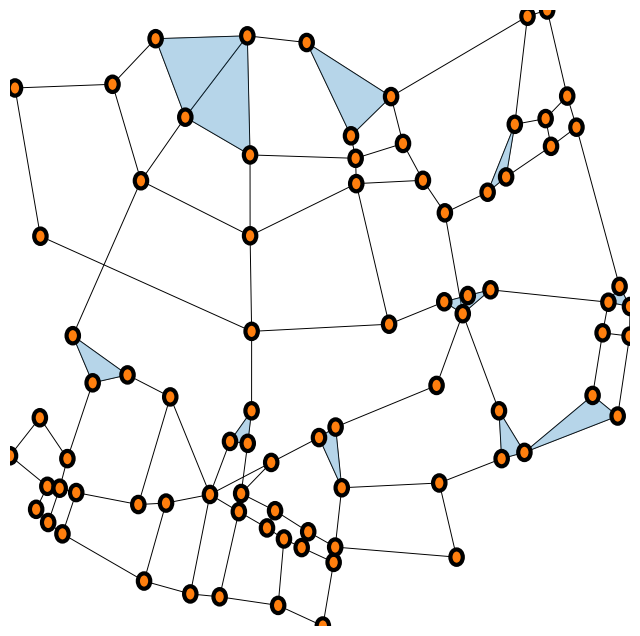

In [8]:
from sclibrary.simplicial_complex import SimplicialComplexNetwork

sc = SimplicialComplexNetwork(simplices=simplices, pos=coordinates)
sc.draw_2d()

### Eigendecompostion

In [6]:
k = 1
L1 = sc.hodge_laplacian_matrix(rank=k)
L1U = sc.upper_laplacian_matrix(rank=k)
L1L = sc.lower_laplacian_matrix(rank=k)

In [7]:
import numpy as np
from sclibrary.eigendecomposition import get_harmonic_eigenvectors, get_curl_eigenvectors, get_gradient_eigenvectors

u_h, eigenvecs_h = get_harmonic_eigenvectors(L1)
u_c, eigenvecs_c = get_curl_eigenvectors(L1U)
u_g, eigenvecs_g = get_gradient_eigenvectors(L1L)

In [18]:
L = 10
lam_l = np.diag(L1)
Phi_G = np.array([lam_l ** (l - 1) for l in range(1, L + 1)]).T
Phi_G

array([[1.0000e+00, 2.0000e+00, 4.0000e+00, ..., 1.2800e+02, 2.5600e+02,
        5.1200e+02],
       [1.0000e+00, 2.0000e+00, 4.0000e+00, ..., 1.2800e+02, 2.5600e+02,
        5.1200e+02],
       [1.0000e+00, 2.0000e+00, 4.0000e+00, ..., 1.2800e+02, 2.5600e+02,
        5.1200e+02],
       ...,
       [1.0000e+00, 2.0000e+00, 4.0000e+00, ..., 1.2800e+02, 2.5600e+02,
        5.1200e+02],
       [1.0000e+00, 3.0000e+00, 9.0000e+00, ..., 2.1870e+03, 6.5610e+03,
        1.9683e+04],
       [1.0000e+00, 2.0000e+00, 4.0000e+00, ..., 1.2800e+02, 2.5600e+02,
        5.1200e+02]], dtype=float32)

### Extra

In [24]:
from scipy.linalg import pinv

# Calculate alpha
alpha = pinv(Phi_G) @ np.concatenate([np.array([1]), np.zeros(len(lam_l)-1)])

# Build the filter
H = np.zeros((7, 7))
for l in range(1, L+1):
    H += alpha[l-1] * L1L**(l-1)
    
H

array([[ 4.99989013e-01,  2.52210576e-02, -8.41018630e-03,
        -8.41018630e-03, -8.41018630e-03,  4.01874218e-04,
         4.01874218e-04],
       [ 2.52210576e-02,  4.99989013e-01,  2.52210576e-02,
         4.01874218e-04,  4.01874218e-04, -8.41018630e-03,
         4.01874218e-04],
       [-8.41018630e-03,  2.52210576e-02,  4.99989013e-01,
         2.52210576e-02,  2.52210576e-02, -8.41018630e-03,
         4.01874218e-04],
       [-8.41018630e-03,  4.01874218e-04,  2.52210576e-02,
         4.99989013e-01,  2.52210576e-02,  2.52210576e-02,
        -8.41018630e-03],
       [-8.41018630e-03,  4.01874218e-04,  2.52210576e-02,
         2.52210576e-02,  4.99989013e-01,  4.01874218e-04,
         2.52210576e-02],
       [ 4.01874218e-04, -8.41018630e-03, -8.41018630e-03,
         2.52210576e-02,  4.01874218e-04,  4.99989013e-01,
        -8.41018630e-03],
       [ 4.01874218e-04,  4.01874218e-04,  4.01874218e-04,
        -8.41018630e-03,  2.52210576e-02, -8.41018630e-03,
         4.9998901

In [137]:
# flow geenration
flow = np.random.rand(L1.shape[0], 1)
print("flow", flow)
# analyze frequency components
flow_h = u_h.T @ flow
flow_g = u_g.T @ flow
flow_c = u_c.T @ flow
print("flow_h", flow_h)
print("flow_g", flow_g)
print("flow_c", flow_c)

flow [[0.31004]
 [0.03894]
 [0.10792]
 [0.1813 ]
 [0.45826]
 [0.18989]
 [0.53967]]
flow_h [[ 0.18668]
 [-0.67182]
 [-0.24841]
 [ 0.21872]
 [-0.21247]
 [-0.18961]
 [ 0.05168]]
flow_g [[ 0.18668]
 [-0.67182]
 [-0.24841]
 [ 0.21872]
 [ 0.21247]
 [ 0.16781]
 [-0.18515]]
flow_c [[ 0.1434 ]
 [-0.18961]
 [-0.05168]
 [-0.40154]
 [ 0.37462]
 [ 0.31004]
 [ 0.03894]]
